<a href="https://colab.research.google.com/github/applepieiris/keyframes_extract_tool/blob/master/fiftyone_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall opencv_python_headless

!pip install opencv-python-headless==4.5.4.60

!pip install fiftyone

# sample from the official website <https://voxel51.com/docs/fiftyone/tutorials/uniqueness.html>

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

# Load the CIFAR-10 test split
# Downloads the dataset from the web if necessary
dataset = foz.load_zoo_dataset("cifar10", split="test")

 100% |█████████████| 10000/10000 [5.6s elapsed, 0s remaining, 1.8K samples/s]      
Dataset info written to '/root/fiftyone/cifar10/info.json'
Loading 'cifar10' split 'test'
 100% |█████████████| 10000/10000 [7.2s elapsed, 0s remaining, 1.4K samples/s]      
Dataset 'cifar10-test' created


In [ ]:
dataset.first()

In [ ]:
session = fo.launch_app(dataset)

In [ ]:
import fiftyone.brain as fob

fob.compute_uniqueness(dataset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


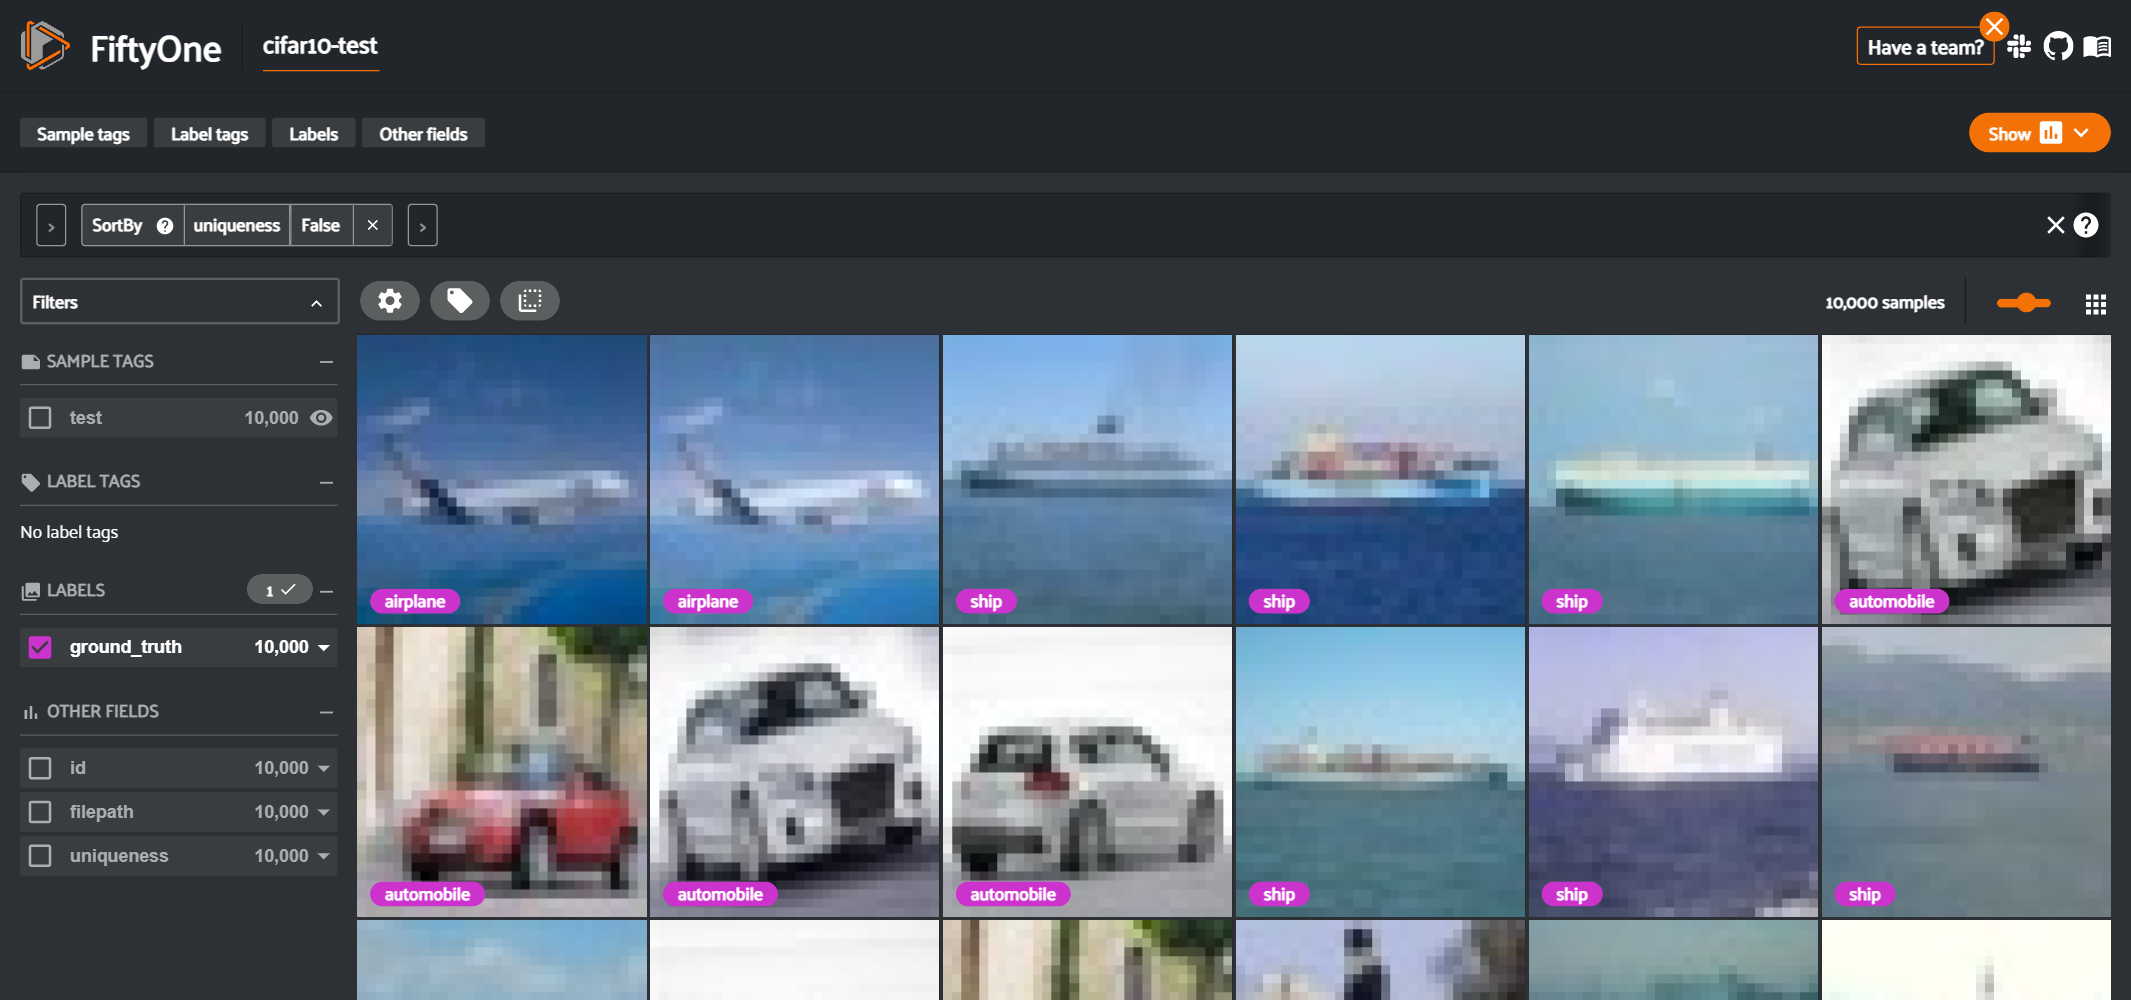

<IPython.core.display.Javascript object>

In [ ]:
# Sort in increasing order of uniqueness (least unique first)
dups_view = dataset.sort_by("uniqueness")

# Open view in the App
session.view = dups_view

读取video类型的数据

In [ ]:
dataset = fo.Dataset.from_videos_dir('./videos/')

 100% |█████████████████████| 2/2 [18.7ms elapsed, 0s remaining, 106.7 samples/s]   


In [ ]:
! rm -r ./videos/2
! rm -r ./videos/1

In [ ]:
# Convert videos to images, sample 1 frame per second
frame_view = dataset.to_frames(sample_frames=True, fps=1)

Sampling video frames...
 100% |█████████████████████| 2/2 [11.4s elapsed, 0s remaining, 0.2 samples/s]  


In [54]:
# 从抽取的帧dir中导入所有帧的图像
image_dataset = fo.Dataset.from_images_dir("./videos/1")

 100% |███████████████████| 94/94 [52.4ms elapsed, 0s remaining, 1.8K samples/s]      


In [55]:
# 加载模型。计算每张图片的向量，这里使用 MobileNet v2 model
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")
embeddings = image_dataset.compute_embeddings(model)
print(embeddings.shape)

 100% |███████████████████| 94/94 [1.2m elapsed, 0s remaining, 1.4 samples/s]      
(94, 1280)


In [37]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarity_matrix = cosine_similarity(embeddings)

print(similarity_matrix.shape)
print(similarity_matrix)

(94, 94)
[[1.         0.99664865 0.99429877 ... 0.83011485 0.84241219 0.74429955]
 [0.99664865 1.         0.99854988 ... 0.82679091 0.84004666 0.72733741]
 [0.99429877 0.99854988 1.         ... 0.82156602 0.83414606 0.72760398]
 ...
 [0.83011485 0.82679091 0.82156602 ... 1.         0.97806601 0.72117796]
 [0.84241219 0.84004666 0.83414606 ... 0.97806601 1.         0.74432025]
 [0.74429955 0.72733741 0.72760398 ... 0.72117796 0.74432025 1.        ]]


In [38]:
n = len(similarity_matrix)

similarity_matrix = similarity_matrix - np.identity(n) # 减去单位矩阵，使得对角线上的1值不影响后续取最高的相似度

In [48]:
id_map = [s.id for s in dataset.select_fields(["id"])]

for idx, sample in enumerate(dataset):
    sample["max_similarity"] = similarity_matrix[idx].max()
    sample.save()

In [ ]:
session = fo.launch_app(image_dataset)

In [52]:
from fiftyone import ViewField as F

dataset.match(F("max_similarity")>0.92)

Dataset:     2022.04.14.07.17.32
Media type:  video
Num samples: 2
Tags:        []
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    max_similarity: fiftyone.core.fields.FloatField
Frame fields:
    id:           fiftyone.core.fields.ObjectIdField
    frame_number: fiftyone.core.fields.FrameNumberField
    filepath:     fiftyone.core.fields.StringField
View stages:
    1. Match(filter={'$expr': {'$gt': [...]}})

In [53]:
id_map = [s.id for s in dataset.select_fields(["id"])]

thresh = 0.90
samples_to_remove = set()
samples_to_keep = set()

for idx, sample in enumerate(dataset):
    if sample.id not in samples_to_remove:
        # Keep the first instance of two duplicates
        samples_to_keep.add(sample.id)
        
        dup_idxs = np.where(similarity_matrix[idx] > thresh)[0]
        for dup in dup_idxs:
            # We kept the first instance so remove all other duplicates
            samples_to_remove.add(id_map[dup])

        if len(dup_idxs) > 0:
            sample.tags.append("has_duplicates")
            sample.save()

    else:
        sample.tags.append("duplicate")
        sample.save()

print(len(samples_to_remove) + len(samples_to_keep))

# If you want to remove the samples from the dataset entirely, uncomment the following line
# dataset.remove_samples(list(samples_to_remove))

IndexError: ignored

Computing embeddings...
 100% |█████████████████| 213/213 [2.6m elapsed, 0s remaining, 1.3 samples/s]      
Generating index...
Index complete
Computing unique samples...
threshold: 1.000000, kept: 89, target: 50
threshold: 2.000000, kept: 30, target: 50
threshold: 1.500000, kept: 46, target: 50
threshold: 1.250000, kept: 67, target: 50
threshold: 1.375000, kept: 53, target: 50
threshold: 1.437500, kept: 50, target: 50
Uniqueness computation complete


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


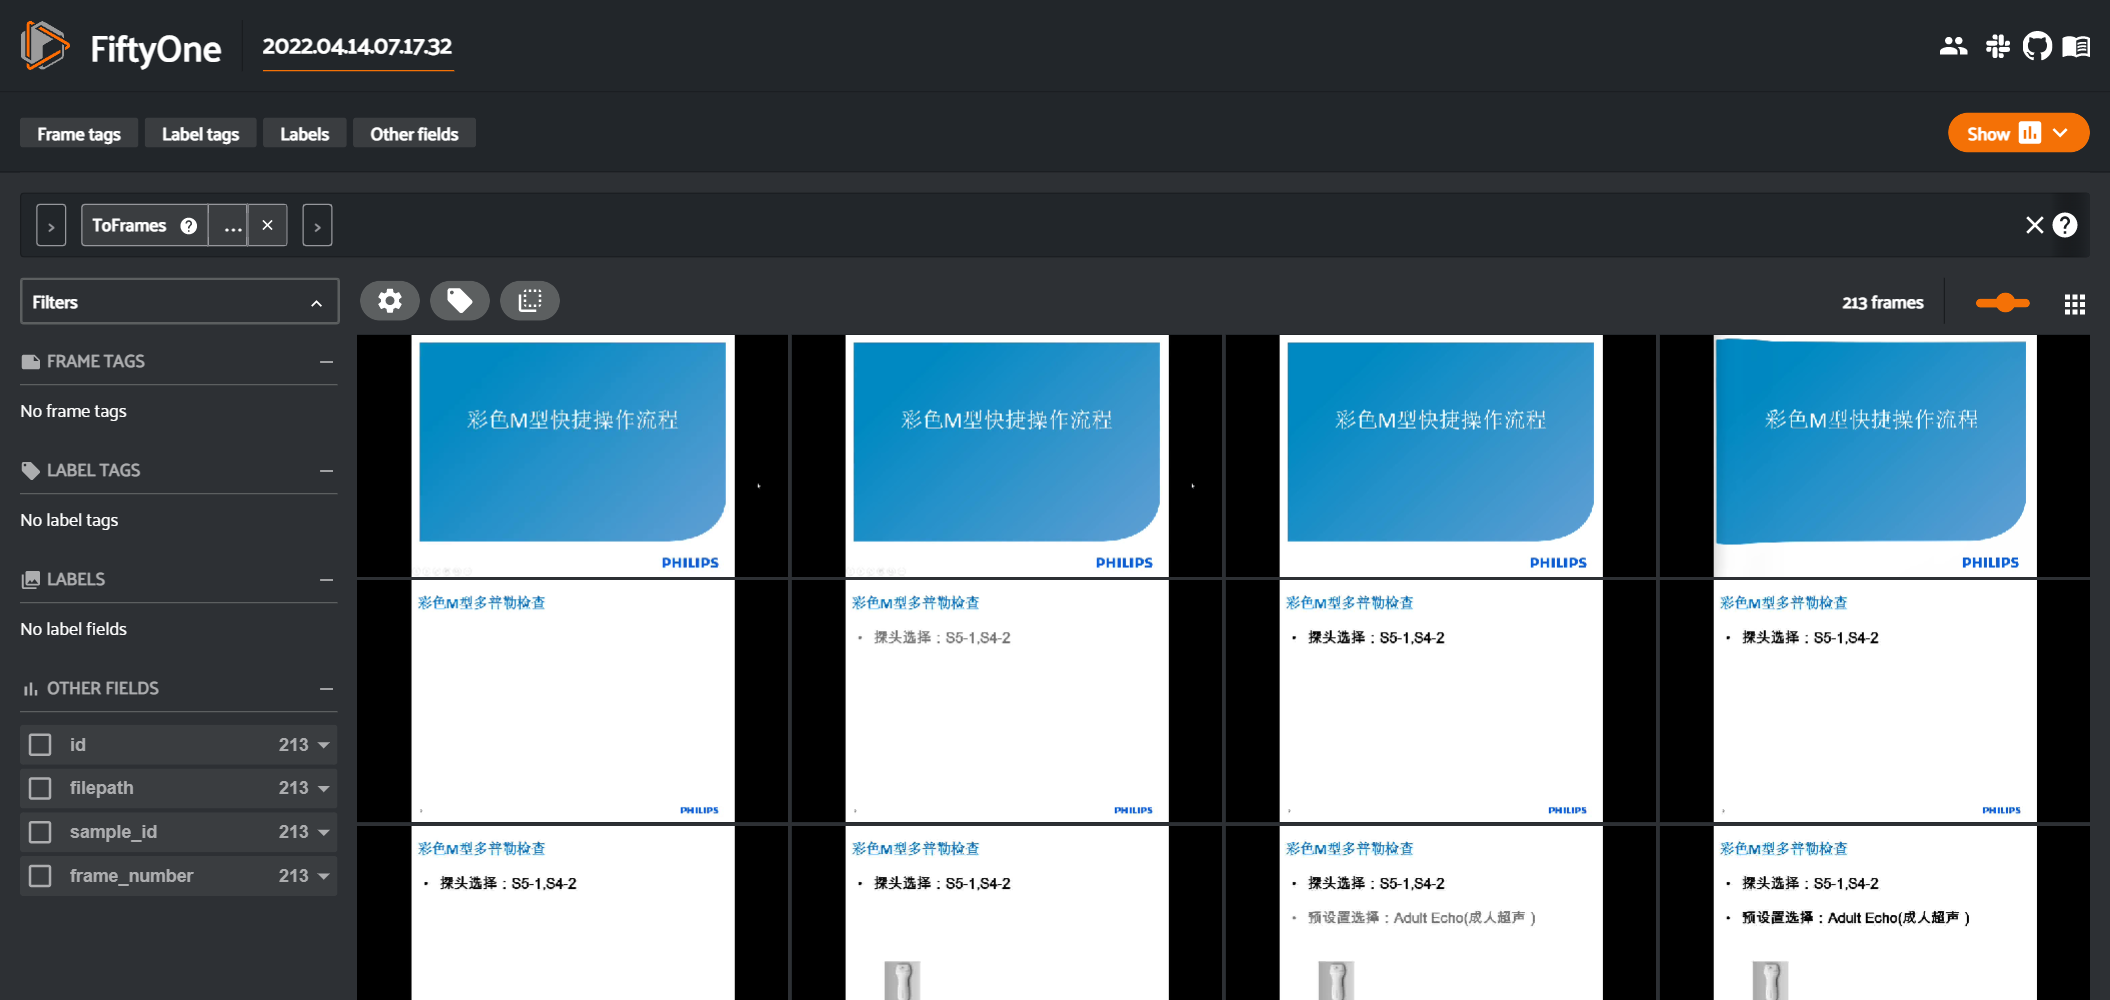

<IPython.core.display.Javascript object>

In [ ]:
# Index images by similarity
results = fob.compute_similarity(frame_view, brain_key="frame_sim")

# Find maximally unique frames
num_unique = 50 # Scale this to whatever you want
results.find_unique(num_unique)
unique_view = frame_view.select(results.unique_ids)

# Visualize in the App
session = fo.launch_app(frame_view)

In [ ]:
session.view = unique_view